# Task 5: Strategy Backtesting — TSLA/BND/SPY
Simulate the strategy using Task 4 optimal weights and compare against a 60/40 SPY/BND benchmark over the last year.

In [1]:
# Ensure project root on path
import os, sys
from pathlib import Path
ROOT = Path.cwd().resolve().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd().resolve()
if str(ROOT) not in sys.path: sys.path.append(str(ROOT))
ROOT


WindowsPath('C:/Users/senta/OneDrive/Documents/Proj/10 Ac/Time-Series-Forecasting-for-Portfolio-Management-Optimization')

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from src.constants.config import TICKERS, START_DATE, END_DATE, INTERVAL, AUTO_ADJUST
from src.utils.data_loader import fetch_yfinance_data, merge_adjusted_close
from src.utils.preprocessing import fill_missing_dates, handle_missing


## 1) Build prices and define backtest window (last ~252 business days)

In [3]:
def build_prices():
    raw = fetch_yfinance_data(TICKERS, START_DATE, END_DATE, interval=INTERVAL, auto_adjust=AUTO_ADJUST)
    prices = merge_adjusted_close(raw, column='Adj Close')
    if prices is None or prices.empty:
        raw2 = fetch_yfinance_data(TICKERS, START_DATE, END_DATE, interval=INTERVAL, auto_adjust=False)
        prices = merge_adjusted_close(raw2, column='Adj Close')
    if prices is None or prices.empty:
        raise RuntimeError('No price data merged. Check network or date range.')
    prices = fill_missing_dates(prices)
    prices = handle_missing(prices, method='interpolate')
    prices = prices.dropna(axis=1, how='all')
    return prices

prices = build_prices()
retn = prices.pct_change().dropna()
# Backtest window: last ~252 business days
BT_DAYS = 252
retn_bt = retn.iloc[-BT_DAYS:] if len(retn) > BT_DAYS else retn.copy()
bt_start, bt_end = retn_bt.index.min(), retn_bt.index.max()
bt_start, bt_end, retn_bt.tail()


(Timestamp('2024-08-13 00:00:00'),
 Timestamp('2025-07-30 00:00:00'),
 Price           TSLA       BND       SPY
 2025-07-24 -0.081970 -0.001232  0.000331
 2025-07-25  0.035244  0.002468  0.004224
 2025-07-28  0.030152 -0.001641 -0.000251
 2025-07-29 -0.013483  0.005205 -0.002638
 2025-07-30 -0.006725 -0.002589 -0.001259)

## 2) Load strategy weights from Task 4 (default: Max Sharpe)

In [4]:
def load_strategy_weights(prefer='Max Sharpe') -> pd.Series:
    path = ROOT / 'data' / 'processed' / 'task4_portfolio_weights.csv'
    if not path.exists():
        # Fallback: equal weights across available assets
        cols = [c for c in ['TSLA','BND','SPY'] if c in retn_bt.columns]
        return pd.Series({c: 1.0/len(cols) for c in cols})
    df = pd.read_csv(path, index_col=0)
    if prefer in df.index:
        s = df.loc[prefer].astype(float)
    else:
        s = df.iloc[0].astype(float)
    # Keep only assets we have returns for
    s = s[[c for c in s.index if c in retn_bt.columns]]
    # Normalize in case of rounding
    s = s / s.sum()
    return s

w_strategy = load_strategy_weights('Max Sharpe')
w_strategy


TSLA    0.0
BND     0.0
SPY     1.0
Name: Max Sharpe, dtype: float64

## 3) Define benchmark weights (60% SPY, 40% BND)

In [5]:
w_bench = pd.Series({'SPY': 0.60, 'BND': 0.40})
# Align to available columns and renormalize if needed
w_bench = w_bench[[c for c in w_bench.index if c in retn_bt.columns]]
w_bench = w_bench / w_bench.sum()
w_bench


SPY    0.6
BND    0.4
dtype: float64

## 4) Simulate strategy and benchmark cumulative returns

In [6]:
# Hold weights over the backtest window (no rebalancing inside this period)
strat_rets = (retn_bt[w_strategy.index] * w_strategy).sum(axis=1)
bench_rets = (retn_bt[w_bench.index] * w_bench).sum(axis=1)

strat_cum = (1 + strat_rets).cumprod()
bench_cum = (1 + bench_rets).cumprod()
strat_cum.tail(), bench_cum.tail()


(2025-07-24    1.204496
 2025-07-25    1.209584
 2025-07-28    1.209281
 2025-07-29    1.206091
 2025-07-30    1.204572
 Freq: B, dtype: float64,
 2025-07-24    1.132404
 2025-07-25    1.136392
 2025-07-28    1.135475
 2025-07-29    1.136042
 2025-07-30    1.134007
 Freq: B, dtype: float64)

## 5) Plot cumulative returns

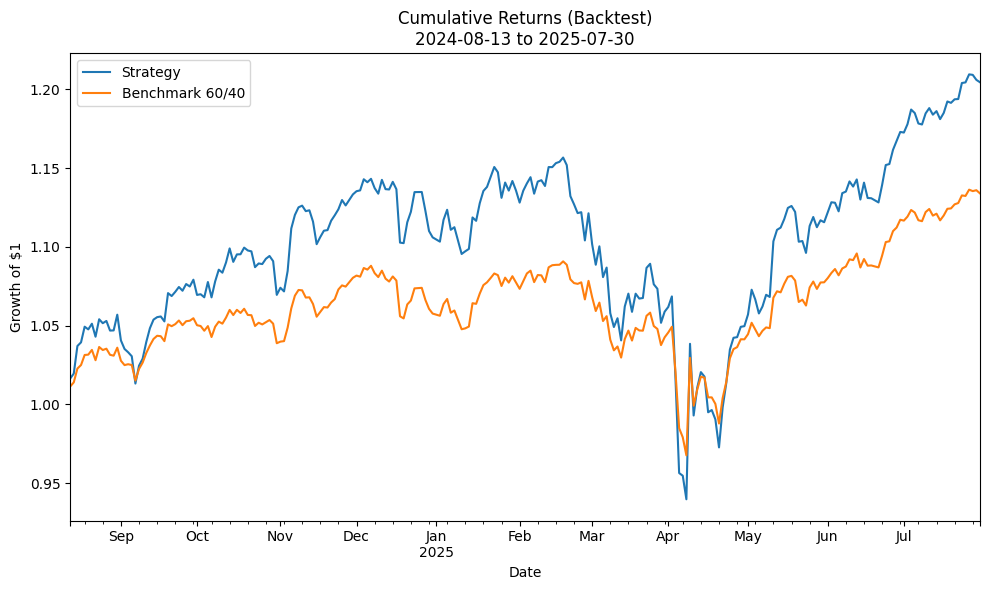

WindowsPath('C:/Users/senta/OneDrive/Documents/Proj/10 Ac/Time-Series-Forecasting-for-Portfolio-Management-Optimization/reports/figures/task5_backtest_cum.png')

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
strat_cum.plot(ax=ax, label='Strategy')
bench_cum.plot(ax=ax, label='Benchmark 60/40')
ax.set_title(f'Cumulative Returns (Backtest)\n{bt_start.date()} to {bt_end.date()}')
ax.set_xlabel('Date'); ax.set_ylabel('Growth of $1')
ax.legend()
plt.tight_layout()
(ROOT / 'reports' / 'figures').mkdir(parents=True, exist_ok=True)
fig_path = ROOT / 'reports' / 'figures' / 'task5_backtest_cum.png'
plt.savefig(fig_path, dpi=150)
plt.show()
fig_path


## 6) Performance metrics (annualized Sharpe and total return)

In [8]:
RISK_FREE_ANNUAL = 0.02
rf_daily = RISK_FREE_ANNUAL / 252.0

def perf_metrics(r: pd.Series) -> dict:
    r = r.dropna().astype(float)
    mu = r.mean() * 252.0
    vol = r.std(ddof=1) * np.sqrt(252.0)
    sharpe = (mu - RISK_FREE_ANNUAL) / vol if vol > 0 else np.nan
    total_ret = (1 + r).prod() - 1
    return {'ann_return': mu, 'ann_vol': vol, 'sharpe': sharpe, 'total_return': total_ret}

m_strat = perf_metrics(strat_rets)
m_bench = perf_metrics(bench_rets)
summary = pd.DataFrame([m_strat, m_bench], index=['Strategy','Benchmark60/40'])
(ROOT / 'data' / 'processed').mkdir(parents=True, exist_ok=True)
summary.to_csv(ROOT / 'data' / 'processed' / 'task5_backtest_metrics.csv')
summary


,ann_return,ann_vol,sharpe,total_return
Strategy,0.204749,0.194121,0.951719,0.204572
Benchmark60/40,0.132870,0.119666,0.943211,0.134007


## 7) Conclusion
Briefly compare final Sharpe and total return. Did the strategy outperform the benchmark? Discuss implications for the model-driven approach and note that this is an initial, simplified backtest (no transaction costs, simplified rebalancing).